In [1]:
%load_ext autoreload
%autoreload 2
import anvil
import anvil.adaround

import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import copy
import torch.optim as optim
import os, pathlib

import matplotlib.pyplot as plt
import numpy as np

base_path = pathlib.Path("/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/models/")
model_path = base_path.joinpath("cifar_model.pth")
adaround_model_path = base_path.joinpath("adaround_model.pth")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(512, 10)
model.load_state_dict(torch.load(model_path, map_location=device))

sample_input = torch.randn(1, 3, 32, 32)

# Loading datasets

In [2]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

full_train_dataset = datasets.CIFAR10(root=base_path.joinpath('data'), train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root=base_path.joinpath('data'), train=False, download=True, transform=transform_test)

train_size = int(0.9 * len(full_train_dataset))  # 45,000
val_size = len(full_train_dataset) - train_size  # 5,000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# 4. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6)
val_dataset.dataset.transform = transform_test
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=6)

In [3]:
images_list = []
for batch in val_loader:
    images = batch[0] if isinstance(batch, (list, tuple)) else batch  # handles (images, labels) or just images
    images_list.append(images)
    total = sum(img.shape[0] for img in images_list)
    if total >= 1000:
        break

images_1 = torch.cat(images_list, dim=0)[:50]
images_1 = images_1.to(device)

In [4]:
model = model.to(device)

In [11]:
adaround_wrapper = anvil.adaround.AdaRoundModelWrapper(model, images_1)
adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(reg_param=100, bitwidth=8, per_channel=False, num_iterations=2000, beta_range=(20, 2))

Quantizizing conv and lin


Processing modules - Current: fc: : 68it [00:44,  1.54it/s]                   


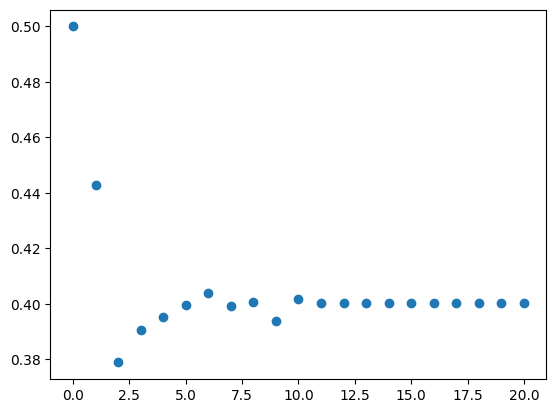

In [12]:
means = []
for h_alpha in adaround_statistics['conv1']['h_alphas']:
    means.append(h_alpha.to("cpu").mean())
plt.scatter([i for i in range(len(means))], means)

In [13]:

layer41conv2 = None
for name, module in quantizized_model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        print(f"Unique weights: {torch.unique(module.weight).shape}")
        if name == "layer4.1.conv2":
            layer41conv2 = module.weight.detach()

baselayer41conv2 = None
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        if name == "layer4.1.conv2":
            baselayer41conv2 = module.weight.detach()

Unique weights: torch.Size([232])
Unique weights: torch.Size([207])
Unique weights: torch.Size([225])
Unique weights: torch.Size([206])
Unique weights: torch.Size([205])
Unique weights: torch.Size([214])
Unique weights: torch.Size([215])
Unique weights: torch.Size([206])
Unique weights: torch.Size([231])
Unique weights: torch.Size([238])
Unique weights: torch.Size([229])
Unique weights: torch.Size([229])
Unique weights: torch.Size([220])
Unique weights: torch.Size([198])
Unique weights: torch.Size([216])
Unique weights: torch.Size([219])
Unique weights: torch.Size([208])
Unique weights: torch.Size([215])
Unique weights: torch.Size([224])
Unique weights: torch.Size([226])
Unique weights: torch.Size([213])


In [8]:
torch.quantile(torch.Tensor([1,2,3,4,5,6,7,8,9,10]), 0.99)

tensor(9.9100)

In [9]:
adaround_statistics['layer4.1.conv2']['h_alphas'][-1]

tensor([[[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]],

         ...,

         [[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.5000, 0.5000],
          [1.0000, 1.0000, 0.5000],
          [1.0000, 1.0000, 0.5000]]],


        [[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.50

In [10]:
sortedd = torch.unique(layer41conv2).msort()
for i, val in enumerate(sortedd):
    if i > 0:
        print(sortedd[i] - sortedd[i-1])

tensor(0.0054, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0012, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0.0006, device='cuda:0')
tensor(0

In [11]:
weights = quantizized_model.layer4[1].conv2.weight

In [12]:
print(f"Unique weights: {torch.unique(weights).shape}")

Unique weights: torch.Size([1698])


In [10]:
torch.unique(weights)

NameError: name 'weights' is not defined

In [10]:
torch.cat(adaround_statistics['conv1']['losses'])

tensor([1.7280e+01, 1.7280e+01, 1.7280e+01, 1.7082e+01, 1.6708e+01, 1.6050e+01,
        1.5552e+01, 1.4975e+01, 1.4166e+01, 1.2858e+01, 1.0568e+01, 6.2637e+00,
        1.3085e+00, 7.3607e-03, 9.7745e-06, 9.7745e-06, 9.7745e-06, 9.7745e-06,
        9.7745e-06, 9.7745e-06])

In [14]:
i = 0

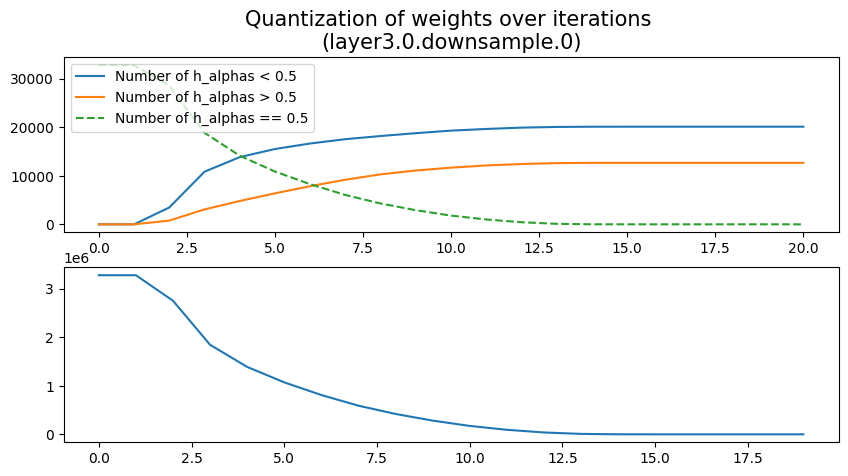

last loss: 0.001733768847770989
last nubmer of h_alphas other than 0 or 1: 0


In [27]:
layer_to_plot = list(adaround_statistics.keys())[i]
#layer_to_plot = 'layer3.0.conv2'
i+=1

raveled_h_alphas = []
zeros_count_arr = []
ones_count_arr = []
other_count_arr = []

for h_alphas in adaround_statistics[layer_to_plot]['h_alphas']:
    raveled = torch.ravel(h_alphas.to("cpu")).numpy()
    zeros_count = np.where(raveled == 0)[0].shape[0]
    ones_count = np.where(raveled  == 1)[0].shape[0]
    other_count = raveled.shape[0] - zeros_count - ones_count

    zeros_count_arr.append(zeros_count)
    ones_count_arr.append(ones_count)
    other_count_arr.append(other_count)

fig, axes = plt.subplots(2,1, figsize=(10, 5))
axes[0].plot(zeros_count_arr, label='Number of h_alphas < 0.5')
axes[0].plot(ones_count_arr, label='Number of h_alphas > 0.5')
axes[0].plot(other_count_arr, "--", label='Number of h_alphas == 0.5')

axes[0].set_title(f"Quantization of weights over iterations \n({layer_to_plot})", fontsize=15)
axes[0].legend()

losses_cpu = torch.cat(adaround_statistics[layer_to_plot]['losses']).to("cpu")
axes[1].plot(losses_cpu)
plt.show()
print(f"last loss: {losses_cpu[-1]}")
print(f"last nubmer of h_alphas other than 0 or 1: {other_count_arr[-1]}")

In [133]:
i = 0

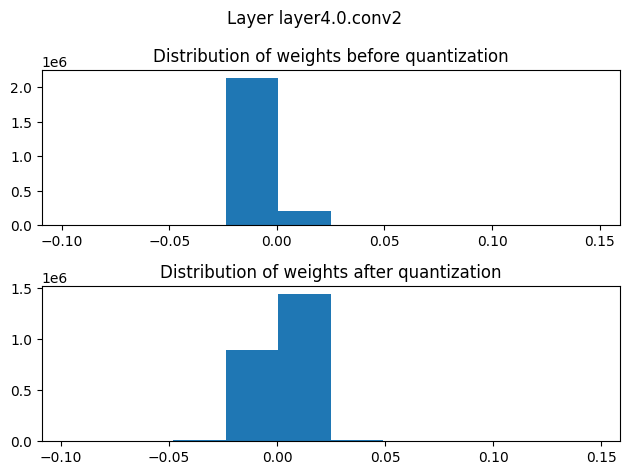

Unique weights before 2355588
Unique weights after 209
Unique h_alphas at the end: tensor([0.0000, 0.5000, 0.9846, 1.0000], device='cuda:0')
Number of h_alphas not 0 or 1: 1295361


In [150]:
layer_to_plot = list(adaround_statistics.keys())[i]
i+=1
module_to_plot_before = dict(model.named_modules())[layer_to_plot]
_weights_before = torch.ravel(module_to_plot_before.weight.to("cpu").detach())

module_to_plot_after = dict(quantizized_model.named_modules())[layer_to_plot]
_weights_after = torch.ravel(module_to_plot_after.weight.to("cpu").detach())

fig, axes = plt.subplots(2,1)
axes[0].hist(_weights_before)
axes[1].hist(_weights_after)


axes[0].set_title("Distribution of weights before quantization")
axes[1].set_title("Distribution of weights after quantization")
fig.suptitle(f"Layer {layer_to_plot}")
plt.tight_layout()
plt.show()


print("Unique weights before", torch.unique(_weights_before).shape[0])
print("Unique weights after", torch.unique(_weights_after).shape[0])
print(f"Unique h_alphas at the end: {torch.unique(adaround_statistics[layer_to_plot]['h_alphas'][-1])}")
end_h_alphas = torch.ravel(adaround_statistics[layer_to_plot]['h_alphas'][-1]).cpu().numpy()
print(f"Number of h_alphas not 0 or 1: {end_h_alphas.shape[0] - np.where(end_h_alphas == 0)[0].shape[0] - np.where(end_h_alphas == 1)[0].shape[0]}")

In [15]:
def evaluate_model(model, dataloader, device):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return all_labels, all_preds

In [20]:
from sklearn import metrics

In [56]:
y_true, y_pred = evaluate_model(model, test_loader, 'cuda:0')
print(f"accuracy before quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score before quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy before quantization: 0.8258
f1 score before quantization: 0.8268


In [ ]:
y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')
print(f"accuracy after quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score after quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy before quantization: 0.8243
f1 score before quantization: 0.8254


**one channel quantization, 2 bits, 1 calibration sample(RANDOM)** <br>
acc : 0.2918

# Grid search

In [ ]:
lr : [0.05, 0.01, 0.005, 0.001]
reg_param: [0.1, 0.07, 0.05, 0.01, 0.005]
num_iteration: [500, 1000, 2000, 3000, 4000]
beta_range: [(10, 2), (20, 2), (40,2), (20,1), (20,0.5)]

In [100]:
params = {
    'bitwidth' : 8,
    'reg_param' : 0.05,
    'num_iterations' : 2000,
    'per_channel' : False,
    'beta_range' : (20, 2),
    'optimizer_lr' : 0.005

}

In [94]:
adaround_wrapper = anvil.adaround.AdaRoundModelWrapper(model, images_1)
adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(**params)

Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.001


Processing modules - Current: fc: : 68it [00:44,  1.52it/s]                   


In [95]:
y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')

parameter_search[int(np.max(list(parameter_search.keys())) + 1)] = {
    'params' : params,
    'accuracry' : metrics.accuracy_score(y_true, y_pred),
    'f1_Score' : metrics.f1_score(y_true, y_pred, average='macro'),
    'y_pred' : y_pred,
    'y_true' : y_true
}

In [96]:
parameter_search

{0: {'params': {'bitwidth': 8,
   'reg_param': 0.01,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8224,
  'f1_Score': 0.8235657650517343,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 1: {'params': {'bitwidth': 8,
   'reg_param': 0.05,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8235,
  'f1_Score': 0.8245692559755922,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 2: {'params': {'bitwidth': 8,
   'reg_param': 0.1,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8231,
  'f1_Score': 0.8242453575956576,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 3: {'params': {'bitwidth': 8,
   'reg_param': 0.05,
   'num_iterations': 500,
 

# Mean acc

In [127]:
accuracies = []
for i in range(5):
    indices = torch.randperm(images.size(0))[:100]
    sample_images = torch.cat(images_list, dim=0)[indices]
    
    adaround_wrapper = anvil.adaround.AdaRoundModelWrapper(model, sample_images)
    adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(**params)

    y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')
    accuracies.append(metrics.accuracy_score(y_true, y_pred))

Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


In [139]:
y_true, y_pred = evaluate_model(model, test_loader, 'cuda:0')
print(f"accuracy before quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score before quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy before quantization: 0.8258
f1 score before quantization: 0.8268


In [138]:
print(f"Adaround: {np.mean(accuracies)} +- {np.std(accuracies):.4f}")

Adaround: 0.82568 +- 0.0009
